In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import time as t
import matplotlib.pyplot as plt

# CPU CODE

## 1. Definir o número de cenários

In [3]:
ncenarios=np.uint32(1e8)

In [4]:
def generateScenario():
    
    e1 = 2*np.random.random() -1
    e2 = 2*np.random.random() -1
    e3 = 2*np.random.random() -1
    
    t1 = 2 + 1*e1
    t2 = 5 + 1*e2
    t3 = 2 + 0.5*e3
    
    tempo = t1 + t2 + t3
    custo = 100000*tempo
    
    return tempo, custo

## 2. Simulação dos cenários

In [5]:
cenarios_tempo = np.zeros(ncenarios)
cenarios_custo = np.zeros(ncenarios)

start = t.time()

for ncen in range(ncenarios):
    cenarios_tempo[ncen] , cenarios_custo[ncen] = generateScenario()
    
total_time_cpu = t.time() - start

## 3. Resultados

In [6]:
print('CPU em %f segundos. ' % total_time_cpu)

CPU em 181.391557 segundos. 


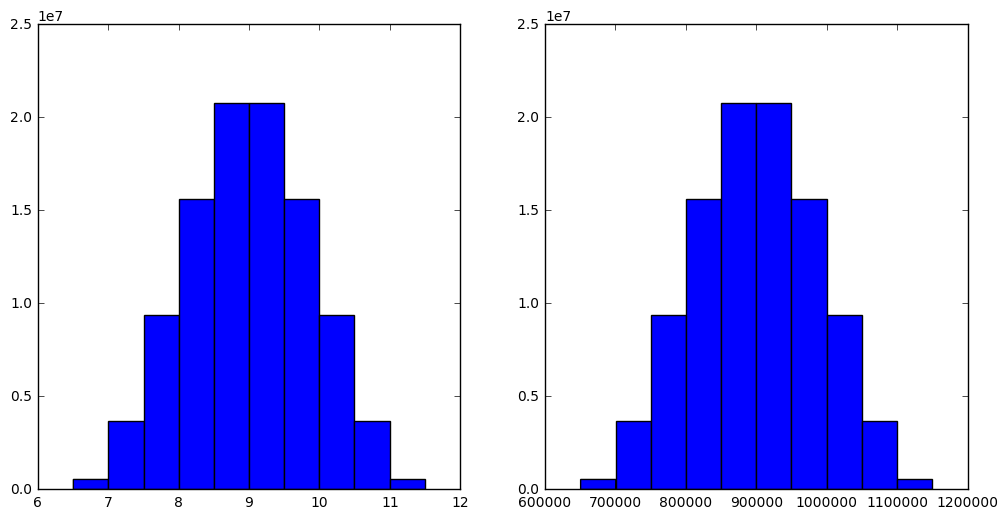

In [7]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.hist(cenarios_tempo)
plt.subplot(122)
plt.hist(cenarios_custo)
plt.show()

In [8]:
cenarios_custo_ok=np.sum(np.apply_along_axis(lambda x: x>1000000, axis =0 , arr=cenarios_custo))
p = (cenarios_custo_ok/len(cenarios_custo))*100
print('Probabilidade do custo passar os 1000000 é : %f' % p)

Probabilidade do custo passar os 1000000 é : 13.548622


 # GPU CODE

In [9]:
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
from pycuda.curandom import rand as curand

## 1. Definir o cenário:

In [10]:
kernel = SourceModule("""

__device__ void generateCenarioGPU(float &tempo , float &custo, float *rand)
{
    float t1 , t2 , t3 , e1 , e2 , e3;
    
    e1 = 2*rand[0] - 1;
    e2 = 2*rand[1] - 1;
    e3 = 2*rand[2] - 1;
    
    t1 = 2 + 1*e1;
    t2 = 5 + 1*e2;
    t3 = 2 + 0.5*e3;
    
    tempo = t1 + t2 + t3;
    custo = 100000*tempo;
}

__global__ void generateCenariosGPU(float *cenarios_tempo, float* cenarios_custo, float *rand , 
unsigned int numcenarios)
{
    const unsigned int thread = blockIdx.x * blockDim.x + threadIdx.x ;
    const unsigned int numthreads = blockDim.x * gridDim.x;
    
    for(unsigned int i=0; i < numcenarios ; i+=numthreads)
        generateCenarioGPU(cenarios_tempo[thread + i], cenarios_custo[thread + i], &rand[i*3]);    
}
""")

generateCenariosGPU = kernel.get_function('generateCenariosGPU')

## Simular os cenários:

In [11]:
cenarios_tempo_gpu = gpuarray.zeros(ncenarios, np.float32)
cenarios_custo_gpu = gpuarray.zeros(ncenarios, np.float32)

start = t.time()
rand_gpu = curand(3*ncenarios, dtype=np.float32)
generateCenariosGPU(cenarios_tempo_gpu, cenarios_custo_gpu, rand_gpu , ncenarios, \
                    block=(256,1,1) , grid=(32,1))
total_time_gpu = t.time() - start

## Visualização de Resultados

In [12]:
print('GPU: em %f secs' % total_time_gpu)

GPU: em 0.150039 secs


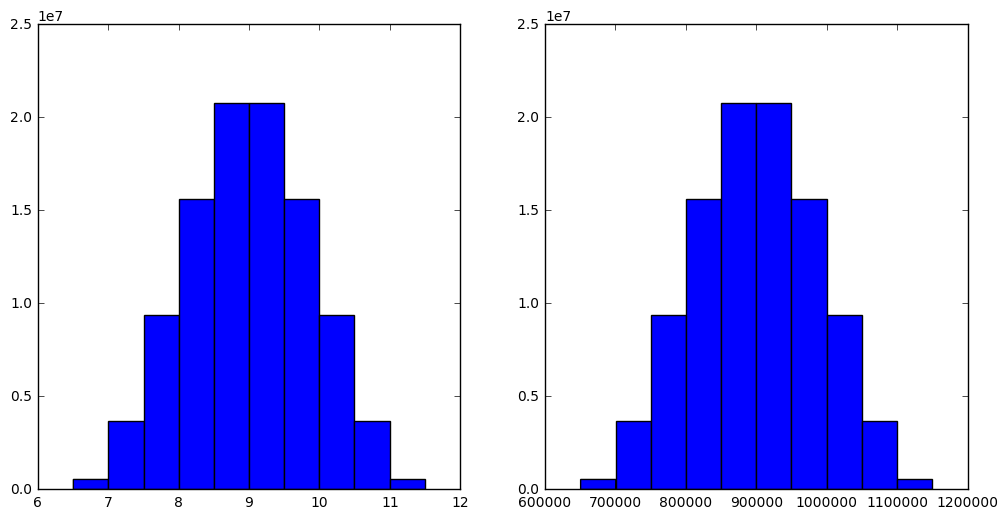

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.hist(cenarios_tempo)
plt.subplot(122)
plt.hist(cenarios_custo)
plt.show()

In [14]:
cenarios_custo_cpu = cenarios_custo_gpu.get()
cenarios_custo_ok_cpu = np.sum(np.apply_along_axis(lambda x:x>1000000, axis=0 , \
                                                   arr=cenarios_custo_cpu))
p = (cenarios_custo_ok_cpu/len(cenarios_custo_cpu))*100
print('Probabilidade de passar R$ 1000000 é %f' % p )

Probabilidade de passar R$ 1000000 é 13.426688


In [15]:
speedup = total_time_cpu/total_time_gpu
print ('speedup %f ' % speedup)

speedup 1208.959214 
